# Tradução automática com o modelo encoder-decoder

<table>
<tr>
<td>
<img align="middle"  width='600' heith='150'   src='images/enc_dec.png'>
</td>
</tr>
</table>


Nesse notebook vamos usar um dataset de pares de sentenças em inglês e português para treinar uma versão simples da arquitetura encoder-decoder. Os dados foram retirados do site [Tatoeba](https://tatoeba.org/eng/).

In [1]:
# notebook feito para a versão 0.4.1 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
import time
import math
from plots.plots import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# % matplotlib inline

In [2]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

## Manipulação inicial dos dados

Em primeiro lugar, vamos pegar todos os pares se sentenças

In [3]:
eng = []
pt = []

with open("data/eng@pt.txt", "r") as f:
    for line in f:
        break_point = line.find("@")
        eng.append(line[:break_point])
        pt.append(line[break_point+1:].strip())
        
eng_pt_pairs = [(e,p) for e,p in zip(eng, pt)]

Agora vamos dividir o dataset em treino, validação e teste

In [4]:
valid_break = int(len(eng_pt_pairs) * 0.8)
test_break = valid_break + int((len(eng_pt_pairs) - valid_break) * 0.5)
np.random.shuffle(eng_pt_pairs)


train_pairs = eng_pt_pairs[:valid_break]
valid_pairs = eng_pt_pairs[valid_break:test_break]
test_pairs = eng_pt_pairs[test_break:]

print("training size = ", len(train_pairs))
print("valid size = ", len(valid_pairs))
print("test size = ", len(test_pairs))

training size =  96840
valid size =  12105
test size =  12106


Vamos definir a classe Lang para guardar o vocabulário de cada lingua.

In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Para deixar o as sentenças padronizadas, vamos fazer usar certas funções de normalização

In [6]:
def unicodeToAscii(s):
    """
    Turn a Unicode string to plain ASCII

    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    """
    Lowercase, trim, and remove non-letter characters
    """
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'[+-]?\d+(?:\.\d+)?', "N", s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub('[^a-zA-z0-9\s]', '', s)
    return s

In [7]:
print("===Exemplo de normalização===\n")


print("===Antes===")

for t in train_pairs[0:4]:
    p1, p2 = t[0], t[1]
    print(p2)
    
print("\n===Depois===")

for t in train_pairs[0:4]:
    p1, p2 = t[0], t[1]
    p1 = normalizeString(p1)
    p2 = normalizeString(p2)
    print(p2)



===Exemplo de normalização===

===Antes===
Estamos aqui agora.
Estou feliz que isso tenha acabado.
Quem é o responsável por deixar a janela aberta?
Por que você quer falar comigo?

===Depois===
estamos aqui agora 
estou feliz que isso tenha acabado 
quem e o responsavel por deixar a janela aberta 
por que voce quer falar comigo 


## Olhando os dados

Estamos lidando com pares de sentença. Podemos ver como é a distribuição dos tamanhos no dataset

In [8]:
train_pairs_nor = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in train_pairs]
valid_pairs_nor = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in valid_pairs]
test_pairs_nor = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in test_pairs]

all_text_pairs_en = [s1 for s1,_ in train_pairs_nor] + [s1 for s1,_ in valid_pairs_nor] + [s1 for s1,_ in valid_pairs_nor]
all_text_pairs_pt = [s1 for _,s1 in train_pairs_nor] + [s1 for _,s1 in valid_pairs_nor] + [s1 for _,s1 in valid_pairs_nor]
all_text_pairs = list(zip(all_text_pairs_en, all_text_pairs_pt))

en_sizes  = [len(s.split(" ")) for s in all_text_pairs_en]
pt_sizes  = [len(s.split(" ")) for s in all_text_pairs_pt]

O tamanho das sentenças em inglês:

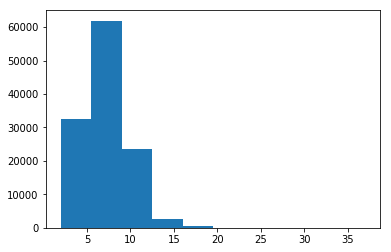

In [9]:
plt.hist(en_sizes)
plt.show()

E o tamanho das sentenças em português:

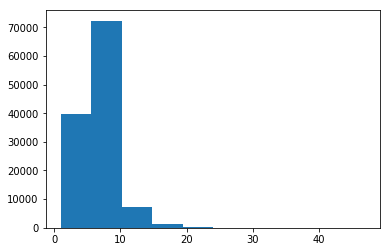

In [10]:
plt.hist(pt_sizes)
plt.show()

Para o treinamento ficar mais fácil de ser executado aqui, vamos trabalhar com sentenças contendo no máximo 4 palavras

In [11]:
MAX_LENGTH = 4

As funções abaixo vão servir para escolher as sentenças de acordo com o tamanho máximo e construir os vocabulários das respectivas linguas.

In [12]:
def readLangs(lang1, lang2, pairs, reverse=False):
    """
    Reverse pairs, make Lang instances
    """
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    pairs = filterPairs(pairs)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



Assim podemos ter as linguas de entrada e saida (*source and target language*) juntamento com os pares de sentenças normalizados.

In [13]:
_, _, train_pairs_nor_f = prepareData("eng",
                                      "pt",
                                       train_pairs_nor)
print()

input_lang, output_lang, _ = prepareData("eng",
                                         "pt",
                                         all_text_pairs)
print()

_, _, valid_pairs_nor_f = prepareData("eng",
                                      "pt",
                                      valid_pairs_nor)

print()

_, _, test_pairs_nor_f = prepareData("eng",
                                     "pt",
                                     test_pairs_nor)

eng 475
pt 702

eng 490
pt 743

eng 135
pt 154

eng 146
pt 166


In [14]:
eng_size = input_lang.n_words
pt_size = output_lang.n_words

### sentences 2 tensors

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
example = random.choice(train_pairs_nor_f)
print(example)

('keep writing ', 'continue escrevendo ')


In [17]:
indexesFromSentence(input_lang,example[0])

[2, 416, 4]

In [18]:
indexesFromSentence(output_lang, example[1])

[2, 593, 4]

## Modelos
### Encoder

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size,
                                      hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, self.num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

### Decoder

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self,
                 hidden_size,
                 output_size,
                 num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, self.num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

## Funções de Treinamento

Observações sobre o treinamento:

- O custo vai ser calculado sobre cada token da linguagem.
- Uma das técnicas que podem ser usadas para melhorar o treinamento é aquela chamada de **teacher forcing**: com uma probabilidade $p$ vamos fazer com o que o decoder use as palavras da tradução de referência para ser a entrada do decorer no passo seguinte.


In [21]:
def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def get_loss(input_tensor,
             target_tensor,
             encoder,
             decoder,
             criterion,
             max_length):

    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        _, topone = decoder_output.topk(1)
        decoder_input = topone.squeeze().detach()

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break
    return loss.item() / target_length


def trainIters(encoder,
               decoder,
               n_iters,
               pairs,
               valid_pairs,
               encoder_path,
               decoder_path,
               batch_size=32,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []
    valid_loss = float("inf")
    
    

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            valid_batch = [tensorsFromPair(random.choice(valid_pairs))
                           for i in range(batch_size)]
            batch_loss = 0
            for t in valid_batch:
                input_sen, output_sen = t
                batch_loss += get_loss(input_sen,
                                       output_sen,
                                       encoder,
                                       decoder,
                                       criterion,
                                       MAX_LENGTH)
            current_valid_loss = batch_loss / batch_size
            
            if current_valid_loss < valid_loss:
                valid_loss = current_valid_loss
                torch.save(encoder.state_dict(), encoder_path)
                torch.save(decoder.state_dict(), decoder_path)
            print("mean training loss = {:.2f}".format(np.mean(plot_losses)))
            print("mean valid loss = {:.2f}".format(current_valid_loss))
            print("time in {} steps:".format(status_every), timeSince(start))
            print()
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))

## Traduzindo com um modelo

Funções de tradução

In [22]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)
    
def save_translation(pairs, encoder, decoder, max_length, out_path):
    with open(out_path, "w") as file:
        file.write("source,candidate,reference,blue,accuracy\n")        
        for tuple_ in pairs:
            source, reference = tuple_
            candidate = translate(encoder,
                                  decoder,
                                  source,
                                  max_length=max_length)
            chencherry = SmoothingFunction()
            blue = sentence_bleu([reference.split(" ")],
                                 candidate.split(" "),
                                 smoothing_function=chencherry.method1)
            if blue >= 0.95:
                acc = 1
            else:
                acc = 0
            line = source + ","
            line += candidate + ","
            line += reference + ","
            line += "{:.3f},".format(blue)
            line += "{}\n".format(acc)
            file.write(line)

## BLUE

Uma métrica popular de tradução automática é a **BLUE** (bilingual evaluation understudy). Ela compara os n-gramas do candidato à tradução com uma tradução padrão. Seja $x$ a sentença de entrada, $\hat{y}$ a tradução que o modelo oferece e $y$ a tradução de referência.

Para definir a nota Blue precisamos definir o n-grama de precisão $P_n$:

\begin{equation}
P_n = \frac{\text{número de } n\text{-gramas em } \hat{y} \text{ e } y}{\text{número de } n\text{-gramas acorrendo em } \hat{y}}
\end{equation}    

Também definimos uma penalidade por previdade ($BP$) para traduções que são mais curtas que a referência. Seja $len(a)$ o tamanho da sequencia $a$, definimos $BP$ como:

\begin{equation}
BP=
\begin{cases}
1 & \text{if } len(\hat{y}) > len(y) \\
\exp\left( 1 - \frac{len(y)}{len(\hat{y})} \right) & \text{caso contrário}
\end{cases}
\end{equation} 


Assim, temos que:

\begin{equation}
BLEU = BP \; \exp \left(\frac{1}{N}  \sum_{n=1}^{N} \log P_n \right)
\end{equation}

Note que:

- Para evitar computar $\log 0$ todas as precisões são alteradas para que elas sempre apresentem algum valor maior que $0$
- Cada $n$-grama do candidato $\hat{y}$ é usado no máximo uma vez
- E como é computacionalmente custoso calcular $n$-gramas com valores altos de $n$, definimos $N=4$.

Primeiro vamos ver como é a tradução de um modelo não treinado.

In [23]:
hidden_size = 10
encoder = EncoderRNN(eng_size, hidden_size)
decoder = DecoderRNN(hidden_size, pt_size)

np.random.shuffle(train_pairs_nor_f)


for t in train_pairs_nor_f[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoder,
                                   decoder,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1]
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    chencherry = SmoothingFunction()
    score = sentence_bleu([reference], candidate, smoothing_function=chencherry.method1)
    print("blue score = {:.2f}".format(score))
    print()


input_sentence : watch yourself 
neural translation : olha improvisei olhou gagueja
reference translation : tome cuidado 
blue score = 0.00

input_sentence : get out 
neural translation : olha improvisei olhou gagueja
reference translation : saia 
blue score = 0.00

input_sentence : slow down 
neural translation : olha improvisei olhou gagueja
reference translation : devagar 
blue score = 0.00



## Treinando alguns modelos

### Primeiro modelo

mean training loss = 3.46
mean valid loss = 3.86
time in 200 steps: 0m 1s

mean training loss = 2.94
mean valid loss = 3.78
time in 200 steps: 0m 1s

mean training loss = 2.89
mean valid loss = 4.12
time in 200 steps: 0m 1s

mean training loss = 2.86
mean valid loss = 3.74
time in 200 steps: 0m 1s

mean training loss = 2.79
mean valid loss = 4.49
time in 200 steps: 0m 1s

mean training loss = 2.65
mean valid loss = 4.50
time in 200 steps: 0m 1s

mean training loss = 2.64
mean valid loss = 4.29
time in 200 steps: 0m 1s

mean training loss = 2.55
mean valid loss = 3.81
time in 200 steps: 0m 1s

mean training loss = 2.55
mean valid loss = 4.38
time in 200 steps: 0m 1s

mean training loss = 2.50
mean valid loss = 3.46
time in 200 steps: 0m 1s

mean training loss = 2.45
mean valid loss = 3.32
time in 200 steps: 0m 1s

mean training loss = 2.42
mean valid loss = 3.40
time in 200 steps: 0m 1s

mean training loss = 2.31
mean valid loss = 3.16
time in 200 steps: 0m 1s

mean training loss = 2.25

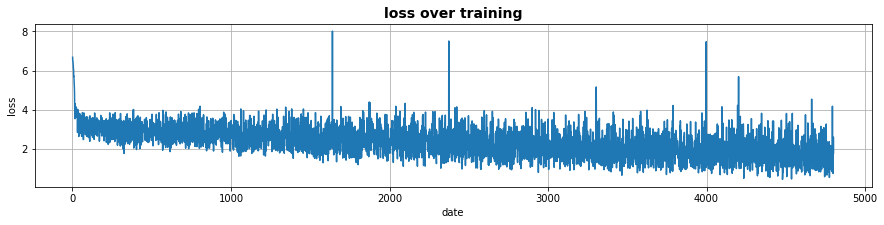

In [24]:
hidden_size = 100
num_layers = 1

encoder = EncoderRNN(eng_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, pt_size, num_layers)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=train_pairs_nor_f,
           valid_pairs=valid_pairs_nor_f,
           encoder_path="encoder1.pkl",
           decoder_path="decoder1.pkl",
           status_every=200,
           learning_rate=0.02,
           teacher_forcing_ratio=1)


np.random.shuffle(train_pairs_nor_f)

save_translation(train_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training1.csv")



df_results = pd.read_csv("training1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

Avaliando o modelo treinado

In [25]:
hidden_size = 100
num_layers = 1

encoder = EncoderRNN(eng_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, pt_size, num_layers)


encoder.load_state_dict(torch.load("encoder1.pkl"))
decoder.load_state_dict(torch.load("decoder1.pkl"))

np.random.shuffle(valid_pairs_nor_f)

save_translation(valid_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "valid1.csv")

df_results = pd.read_csv("valid1.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

mean blue score over valid data = 0.133
mean acc over valid data = 0.000


## Segundo modelo

mean training loss = 3.61
mean valid loss = 3.27
time in 200 steps: 0m 10s

mean training loss = 3.23
mean valid loss = 3.65
time in 200 steps: 0m 10s

mean training loss = 3.10
mean valid loss = 3.12
time in 200 steps: 0m 10s

mean training loss = 2.90
mean valid loss = 2.87
time in 200 steps: 0m 10s

mean training loss = 2.90
mean valid loss = 2.81
time in 200 steps: 0m 10s

mean training loss = 2.86
mean valid loss = 2.87
time in 200 steps: 0m 11s

mean training loss = 2.76
mean valid loss = 2.70
time in 200 steps: 0m 11s

mean training loss = 2.76
mean valid loss = 2.54
time in 200 steps: 0m 10s

mean training loss = 2.54
mean valid loss = 2.74
time in 200 steps: 0m 10s

mean training loss = 2.58
mean valid loss = 2.97
time in 200 steps: 0m 10s

mean training loss = 2.43
mean valid loss = 2.68
time in 200 steps: 0m 11s

mean training loss = 2.37
mean valid loss = 3.26
time in 200 steps: 0m 10s

mean training loss = 2.23
mean valid loss = 2.92
time in 200 steps: 0m 10s

mean trainin

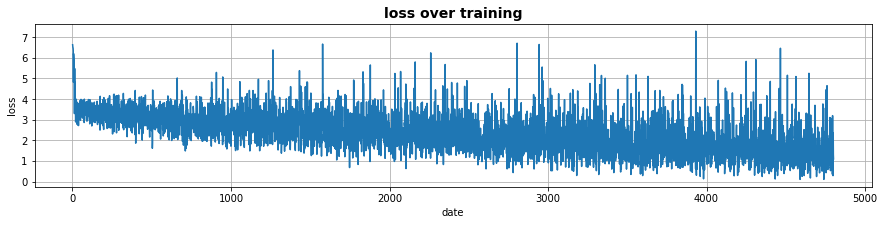

In [26]:
hidden_size = 300
num_layers = 3

encoder = EncoderRNN(eng_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, pt_size, num_layers)

trainIters(encoder=encoder,
           decoder=decoder,
           n_iters=5000,
           pairs=train_pairs_nor_f,
           valid_pairs=valid_pairs_nor_f,
           encoder_path="encoder2.pkl",
           decoder_path="decoder2.pkl",
           status_every=200,
           learning_rate=0.02,
           teacher_forcing_ratio=0.2)


np.random.shuffle(train_pairs_nor_f)

save_translation(train_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "training2.csv")



df_results = pd.read_csv("training2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over training data = {:.3f}".format(blue))
print("mean acc over training data = {:.3f}".format(acc))

Avaliando o resultado do segundo treinamento

In [27]:
hidden_size = 300
num_layers = 3

encoder = EncoderRNN(eng_size, hidden_size, num_layers)
decoder = DecoderRNN(hidden_size, pt_size, num_layers)


encoder.load_state_dict(torch.load("encoder2.pkl"))
decoder.load_state_dict(torch.load("decoder2.pkl"))

np.random.shuffle(valid_pairs_nor_f)

save_translation(valid_pairs_nor_f[0:1000],
                 encoder,
                 decoder,
                 MAX_LENGTH,
                 "valid2.csv")

df_results = pd.read_csv("valid2.csv")
acc = np.mean(df_results.accuracy.values)
blue = np.mean(df_results.blue.values)
print("mean blue score over valid data = {:.3f}".format(blue))
print("mean acc over valid data = {:.3f}".format(acc))

mean blue score over valid data = 0.135
mean acc over valid data = 0.000


## Próximos passos

- Melhora a busca de hiper pâmetros: **tamanho da célula de memória**, **learning rate**, **teaching forcing**.

- Tente construir modelos fazendo uso da classe `nn.LSTM`.

- Tente treinar os modelos com outros tamanhos máximos de sentenças. O ideal é ter um modelo de tradução para **todos os tamanhos**.